In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from IPython.display import display, HTML
from scipy.stats import f
import seaborn as sns
from pprint import pprint
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
import warnings
import pickle
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost import plot_importance
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
def prepare_df(df, rows_to_include=1):
    
    def stats(df,rows_to_include, future=6):
        is_sick = bool(len(df[df.SepsisLabel == 1]))
        if is_sick:
            index = df[df.SepsisLabel == 1].index[0]
            df = df[:index + future]
        df = df.tail(rows_to_include + future).mean(axis=0)
        return df
    
    labels = df.groupby("level_0").apply(lambda x: len(set(x.SepsisLabel) & set([1]))).rename("level_1")
    df = df.merge(labels, on='level_0')
    df['label'] = df['level_1']
    df = df.drop("level_1", axis=1)
    df_last_row = df.groupby("level_0").apply(lambda x: stats(x, rows_to_include, future = 1)).drop(["level_0", 'SepsisLabel'], axis=1)
    return df_last_row

In [4]:
def impute_null_values(train_df, test_df=None, method='mean', k=1):
    """
    Function that imputes null values of a pandas dataframe using mean/median or k-NN imputation.
    
    Parameters:
    train_df (pd.DataFrame): dataframe containing training data with null values to be imputed.
    test_df (pd.DataFrame): dataframe containing test data with null values to be imputed (default=None).
                             If None, only the train set will be imputed.
    method (str): 'mean' or 'median' for mean/median imputation or 'knn' for k-NN imputation (default='mean').
    k (int): number of neighbors to use for k-NN imputation (default=5).
    
    Returns:
    pd.DataFrame: dataframe with imputed null values.
    """
    # Make a copy of the original train dataframe to avoid modifying it.
    imputed_train_df = train_df.copy()
    if method is None:
        return train_df, test_df
    if method == 'mean':
        # Replace null values with the mean of each column from the train set.
        imputed_train_df.fillna(imputed_train_df.mean(), inplace=True)
        
    elif method == 'median':
        # Replace null values with the median of each column from the train set.
        imputed_train_df.fillna(imputed_train_df.median(), inplace=True)
        
    elif method == 'knn':
        # Replace null values with k-NN imputation using the values from the train set.
        imputer = KNNImputer(n_neighbors=k)
        imputed_array = imputer.fit_transform(imputed_train_df)
        imputed_train_df = pd.DataFrame(imputed_array, columns=imputed_train_df.columns)
        
    else:
        raise ValueError("Invalid imputation method. Choose either 'mean', 'median' or 'knn'.")
    
    if test_df is not None:
        # Make a copy of the original test dataframe to avoid modifying it.
        imputed_test_df = test_df.copy()
        
        if method == 'mean':
            # Replace null values with the mean of each column from the train set.
            imputed_test_df.fillna(imputed_train_df.mean(), inplace=True)
        
        elif method == 'median':
            # Replace null values with the median of each column from the train set.
            imputed_test_df.fillna(imputed_train_df.median(), inplace=True)
            
        elif method == 'knn':
            # Replace null values with k-NN imputation using the values from the train set.
            imputed_array = imputer.transform(imputed_test_df)
            imputed_test_df = pd.DataFrame(imputed_array, columns=imputed_test_df.columns)
            
        else:
            raise ValueError("Invalid imputation method. Choose either 'mean', 'median' or 'knn'.")
        
        return imputed_train_df, imputed_test_df
    
    else:
        return imputed_train_df


In [5]:
model_list = [model for model in os.listdir() if '.pkl' in model]
random_forest = ['knn_RF.pkl', 'mean_RF.pkl', 'median_RF.pkl']
adaboost = ['rows_10_ADA.pkl', 'rows_1_ADA.pkl', 'rows_5_ADA.pkl']
xgboost = ['xgboost_10_rows_back.pkl', 'xgboost_1_rows_back.pkl', 'xgboost_5_rows_back.pkl']

In [6]:
# train_no_null, test_no_null = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), None, k=1)
# train_mean, test_mean = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), 'mean', k=1)
# train_median, test_median = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), 'median', k=1)
# train_knn, test_knn = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), 'knn', k=1)

In [7]:
def open_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

In [8]:
#     cm = confusion_matrix(train['label'].to_numpy(), train_pred, normalize='true')
#     # Plot the confusion matrix as a heatmap
#     plt.imshow(cm, cmap='binary', interpolation='None')
#     plt.colorbar()
#     plt.xticks(np.arange(2), ['Negative', 'Positive'])
#     plt.yticks(np.arange(2), ['Negative', 'Positive'])
#     plt.xlabel('Predicted label')
#     plt.ylabel('True label')
#     plt.title('Train dataset')
#     plt.show()

In [9]:
def trainVtest(model, train, test):
    train_pred = model.predict(train.drop("label", axis=1))
    train_f1 = f1_score(train_pred, train['label'].to_numpy())
    
    

    
    test_pred = model.predict(test.drop("label", axis=1))
    test_f1 = f1_score(test_pred, test['label'].to_numpy())

    
    print(f"Train f1: {train_f1}, Test f1: {test_f1}")

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def trainVtest(model, train, test):
    # Train set performance
    train_pred = model.predict(train.drop("label", axis=1))
    train_accuracy = accuracy_score(train_pred, train['label'].to_numpy())
    train_precision = precision_score(train_pred, train['label'].to_numpy())
    train_recall = recall_score(train_pred, train['label'].to_numpy())
    train_f1 = f1_score(train_pred, train['label'].to_numpy())
    train_cm = confusion_matrix(train_pred, train['label'].to_numpy(), normalize='true')
    
    # Test set performance
    test_pred = model.predict(test.drop("label", axis=1))
    test_accuracy = accuracy_score(test_pred, test['label'].to_numpy())
    test_precision = precision_score(test_pred, test['label'].to_numpy())
    test_recall = recall_score(test_pred, test['label'].to_numpy())
    test_f1 = f1_score(test_pred, test['label'].to_numpy())
    test_cm = confusion_matrix(test_pred, test['label'].to_numpy(), normalize='true')

    # Print performance metrics
    print("Train Set Metrics:")
    print(f"Accuracy: {train_accuracy:.2f}")
    print(f"Precision: {train_precision:.2f}")
    print(f"Recall: {train_recall:.2f}")
    print(f"F1 Score: {train_f1:.2f}\n")
    
    print("Test Set Metrics:")
    print(f"Accuracy: {test_accuracy:.2f}")
    print(f"Precision: {test_precision:.2f}")
    print(f"Recall: {test_recall:.2f}")
    print(f"F1 Score: {test_f1:.2f}\n")
    
    sns.set_style('whitegrid')
    ax = sns.barplot(x=['Accuracy','Accuracy', 'Precision', 'Precision','Recall', 'Recall', 'F1 Score', 'F1 Score'],
                     y=[train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1],
                    hue=['Train','Test']*4)

    # Set plot title and axes labels
    ax.set(title='Comparison of Four Metrics', xlabel='Metrics', ylabel='Value')
    # Customize plot aesthetics
    sns.despine(left=True)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.show()
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)

    # initialize using the raw 2D confusion matrix 
    # and output labels (in our case, it's 0 and 1)
    display = ConfusionMatrixDisplay(train_cm, display_labels=model.classes_)

    # set the plot title using the axes object
    ax.set(title='Confusion Matrix for the Diabetes Detection Model')

    # show the plot. 
    # Pass the parameter ax to show customizations (ex. title) 
    display.plot(ax=ax)
    plt.show()
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)

    # initialize using the raw 2D confusion matrix 
    # and output labels (in our case, it's 0 and 1)
    display = ConfusionMatrixDisplay(test_cm, display_labels=model.classes_)

    # set the plot title using the axes object
    ax.set(title='Confusion Matrix for the Diabetes Detection Model')

    # show the plot. 
    # Pass the parameter ax to show customizations (ex. title) 
    display.plot(ax=ax)
    plt.show()



#### Women vs Men

In [11]:
def menVwomen(model, train, test):
    train_pred = model.predict(train[train.Gender==1].drop("label", axis=1))
    train_f1 = f1_score(train_pred, train['label'][train.Gender==1].to_numpy())

    test_pred = model.predict(test[test.Gender==1].drop("label", axis=1))
    test_f1 = f1_score(test_pred, test['label'][test.Gender==1].to_numpy())

    print(f"Women\n\tTrain f1: {train_f1}, Test f1: {test_f1}")

    train_pred = model.predict(train[train.Gender==0].drop("label", axis=1))
    train_f1 = f1_score(train_pred, train['label'][train.Gender==0].to_numpy())

    test_pred = model.predict(test[test.Gender==0].drop("label", axis=1))
    test_f1 = f1_score(test_pred, test['label'][test.Gender==0].to_numpy())

    print(f"Men\n\tTrain f1: {train_f1}, Test f1: {test_f1}")

#### Kids vs adults vs Elderly

In [12]:
def adultsVelderly(model, train, test):
    # kids = (train.Age < 18)
    # train_pred = model.predict(train[kids].drop("label", axis=1))
    # train_f1 = f1_score(train_pred, train['label'][kids].to_numpy())
    # kids = (test.Age < 18)
    # test_pred = model.predict(test[kids].drop("label", axis=1))
    # test_f1 = f1_score(test_pred, test['label'][kids].to_numpy())
    # print(f"Kids (Age<18)\n\tTrain f1: {train_f1}, Test f1: {test_f1}")

    adults =  (train.Age <= 55) #& (train.Age >=18) 
    train_pred = model.predict(train[adults].drop("label", axis=1))
    train_f1 = f1_score(train_pred, train['label'][adults].to_numpy())
    adults =  (test.Age <= 55) #& (test.Age >=18) 
    test_pred = model.predict(test[adults].drop("label", axis=1))
    test_f1 = f1_score(test_pred, test['label'][adults].to_numpy())
    print(f"Adults (18<Age<55)\n\tTrain f1: {train_f1}, Test f1: {test_f1}")

    elderly = (train.Age > 55)
    train_pred = model.predict(train[elderly].drop("label", axis=1))
    train_f1 = f1_score(train_pred, train['label'][elderly].to_numpy())
    elderly = (test.Age > 55)
    test_pred = model.predict(test[elderly].drop("label", axis=1))
    test_f1 = f1_score(test_pred, test['label'][elderly].to_numpy())
    print(f"Elderly (55<Age)\n\tTrain f1: {train_f1}, Test f1: {test_f1}")



# XGBoost Analysis

Model name: xgboost_10_rows_back.pkl

Train Set Metrics:
Accuracy: 0.98
Precision: 0.84
Recall: 0.89
F1 Score: 0.86

Test Set Metrics:
Accuracy: 0.96
Precision: 0.70
Recall: 0.77
F1 Score: 0.73



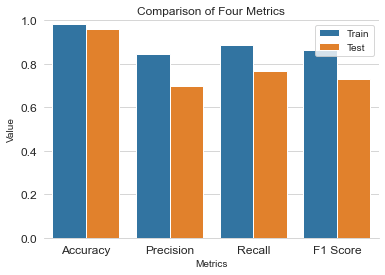


Women
	Train f1: 0.8546583850931677, Test f1: 0.7253521126760564
Men
	Train f1: 0.8759757155247181, Test f1: 0.7402135231316725

Adults (18<Age<55)
	Train f1: 0.8716763005780347, Test f1: 0.6772727272727272
Elderly (55<Age)
	Train f1: 0.8598524762908324, Test f1: 0.75564681724846



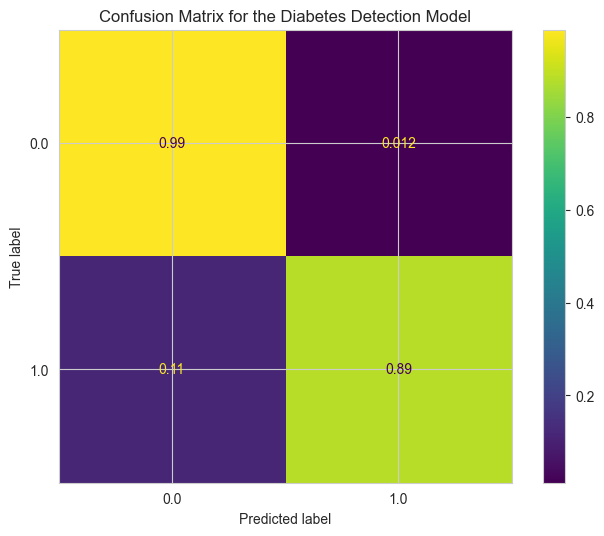

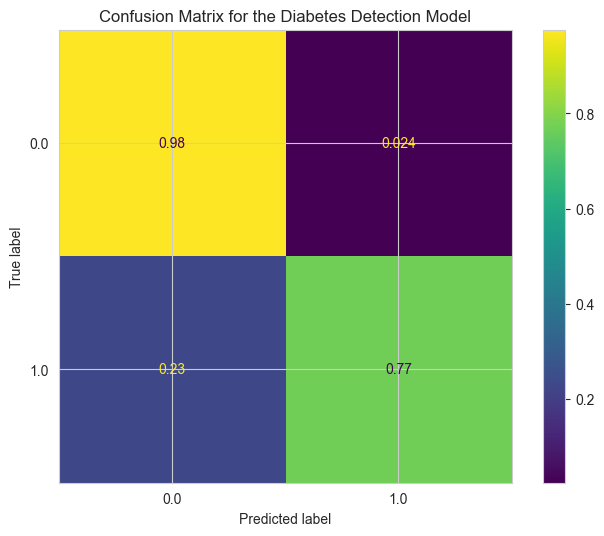

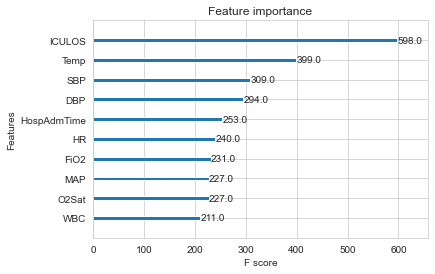

###################################################
Model name: xgboost_1_rows_back.pkl

Train Set Metrics:
Accuracy: 0.98
Precision: 0.76
Recall: 0.88
F1 Score: 0.81

Test Set Metrics:
Accuracy: 0.96
Precision: 0.64
Recall: 0.76
F1 Score: 0.70



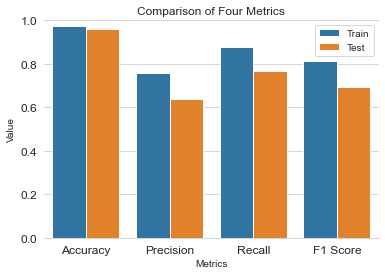


Women
	Train f1: 0.8096795291039895, Test f1: 0.7027027027027026
Men
	Train f1: 0.8184281842818427, Test f1: 0.6838235294117647

Adults (18<Age<55)
	Train f1: 0.8256658595641647, Test f1: 0.6794258373205742
Elderly (55<Age)
	Train f1: 0.8077348066298343, Test f1: 0.702127659574468



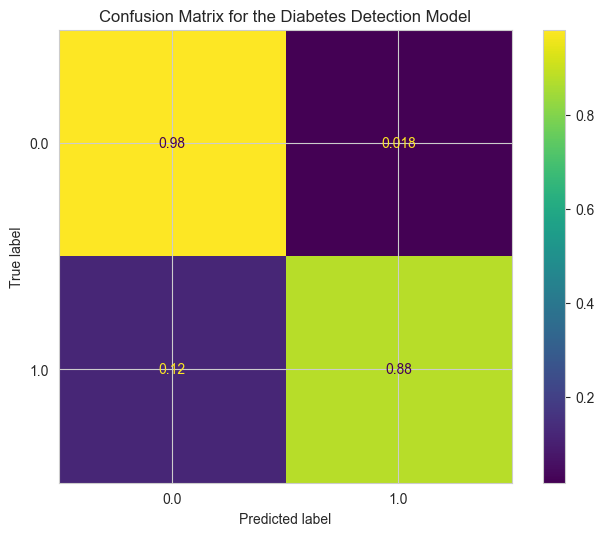

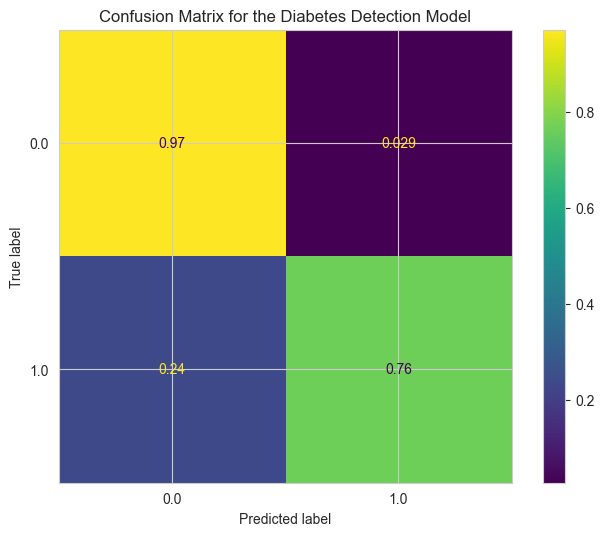

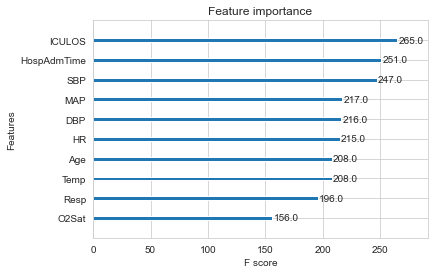

###################################################
Model name: xgboost_5_rows_back.pkl

Train Set Metrics:
Accuracy: 0.97
Precision: 0.75
Recall: 0.87
F1 Score: 0.81

Test Set Metrics:
Accuracy: 0.96
Precision: 0.68
Recall: 0.80
F1 Score: 0.74



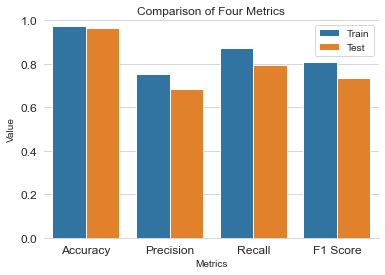


Women
	Train f1: 0.8005284015852047, Test f1: 0.7424425634824667
Men
	Train f1: 0.8160714285714286, Test f1: 0.7259528130671508

Adults (18<Age<55)
	Train f1: 0.8223844282238443, Test f1: 0.7077625570776255
Elderly (55<Age)
	Train f1: 0.8002207505518764, Test f1: 0.748936170212766



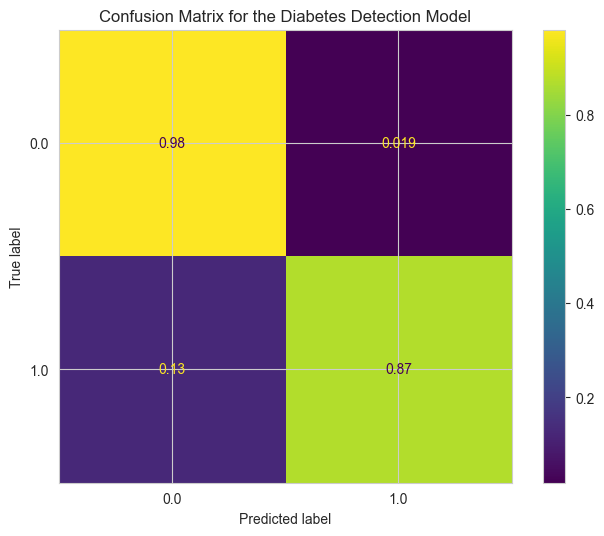

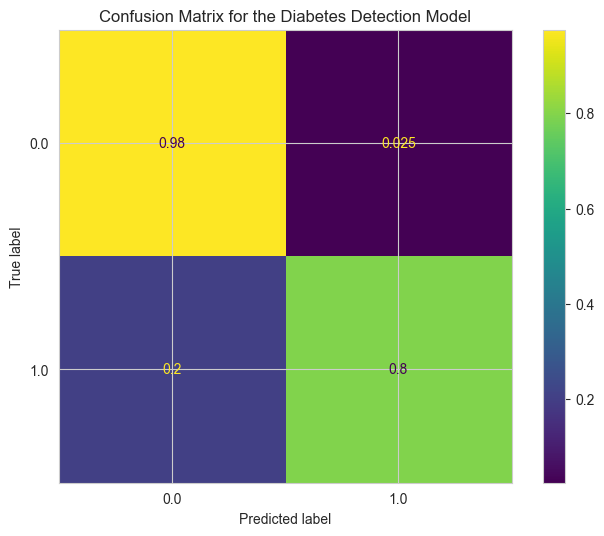

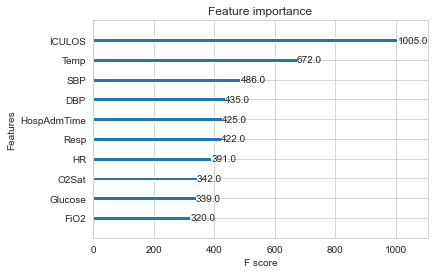

###################################################


In [49]:
for model_name in xgboost:
    rows = int(model_name.split("_")[1])
    train_no_null, test_no_null = impute_null_values(prepare_df(train, rows_to_include=rows), prepare_df(test, rows_to_include=rows), None, k=1)
    model = open_model(model_name)
    print(f"Model name: {model_name}")
    print()
    trainVtest(model, train_no_null, test_no_null)
    print()
    menVwomen(model, train_no_null, test_no_null)
    print()
    adultsVelderly(model, train_no_null, test_no_null)
    print()
    plot_importance(model, max_num_features=10) # top 10 most important features
    plt.show()
    print("###################################################")

# Random Forest

Model name: knn_RF.pkl

Train Set Metrics:
Accuracy: 0.95
Precision: 0.62
Recall: 0.67
F1 Score: 0.64

Test Set Metrics:
Accuracy: 0.94
Precision: 0.53
Recall: 0.59
F1 Score: 0.55



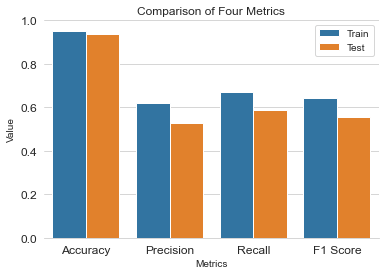

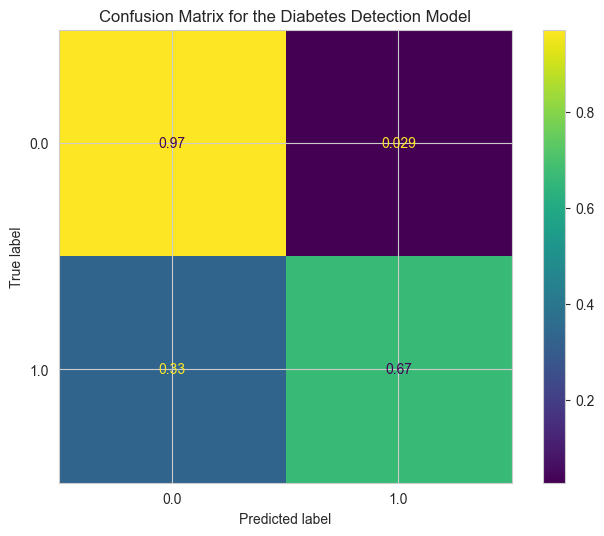

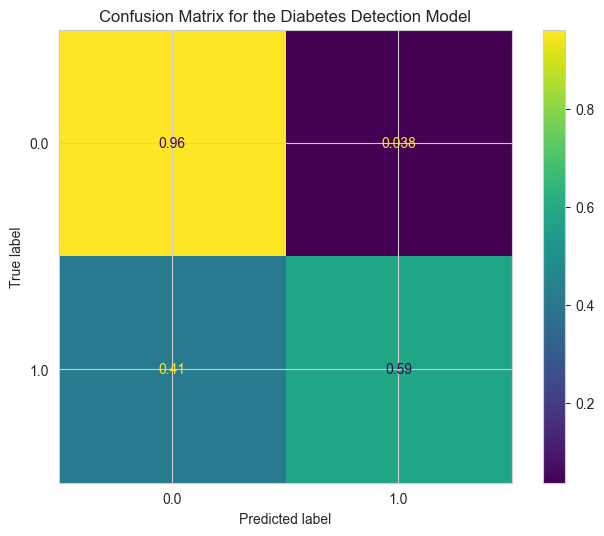


Women
	Train f1: 0.6479750778816199, Test f1: 0.5567502986857825
Men
	Train f1: 0.6399999999999999, Test f1: 0.5508771929824561

Adults (18<Age<55)
	Train f1: 0.6564885496183206, Test f1: 0.503225806451613
Elderly (55<Age)
	Train f1: 0.6387203530060673, Test f1: 0.5796178343949044

###################################################
Model name: mean_RF.pkl

Train Set Metrics:
Accuracy: 0.98
Precision: 0.89
Recall: 0.82
F1 Score: 0.85

Test Set Metrics:
Accuracy: 0.95
Precision: 0.68
Recall: 0.69
F1 Score: 0.68



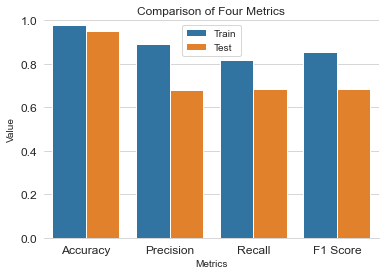

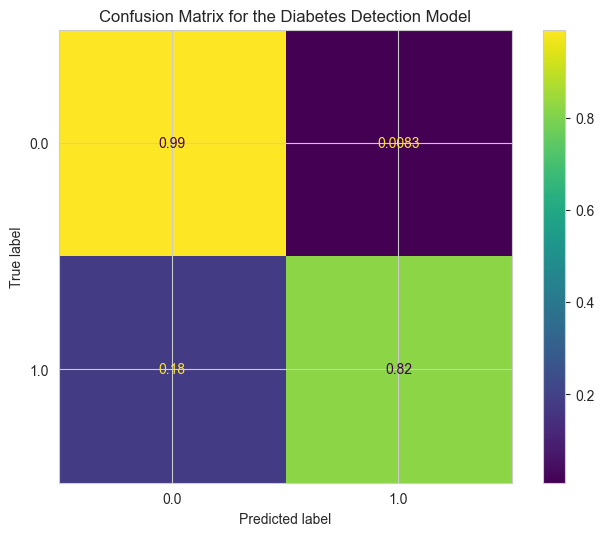

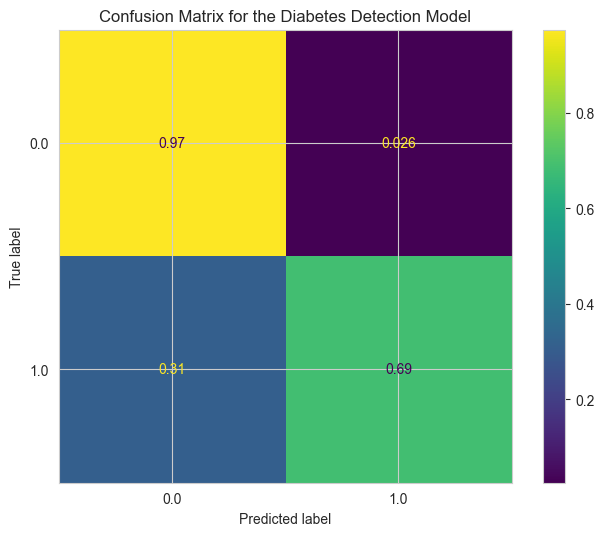


Women
	Train f1: 0.8467322151532677, Test f1: 0.6851211072664359
Men
	Train f1: 0.864600326264274, Test f1: 0.6787479406919275

Adults (18<Age<55)
	Train f1: 0.8534201954397393, Test f1: 0.6596638655462185
Elderly (55<Age)
	Train f1: 0.8544739429695183, Test f1: 0.6933867735470942

###################################################
Model name: median_RF.pkl

Train Set Metrics:
Accuracy: 0.96
Precision: 0.64
Recall: 0.80
F1 Score: 0.71

Test Set Metrics:
Accuracy: 0.95
Precision: 0.56
Recall: 0.70
F1 Score: 0.63



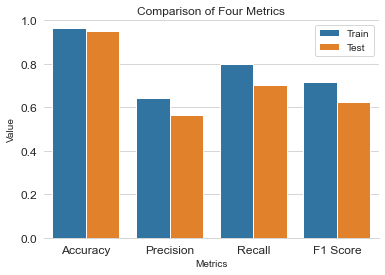

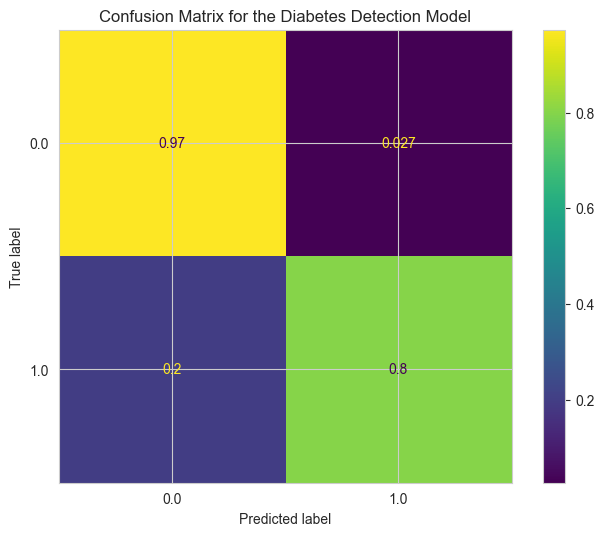

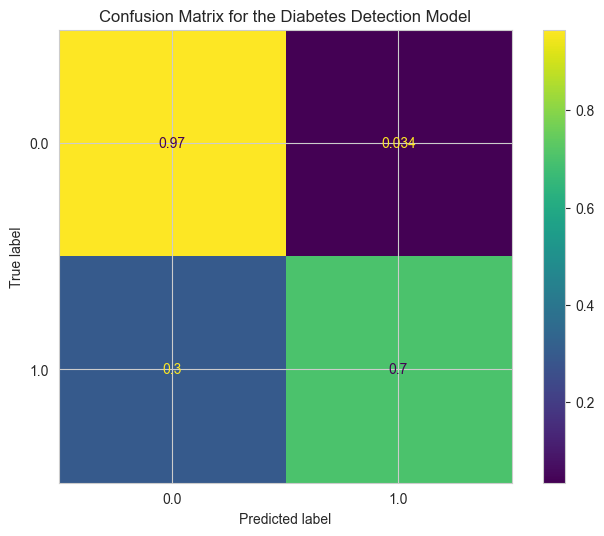


Women
	Train f1: 0.7031039136302295, Test f1: 0.6248431618569636
Men
	Train f1: 0.7301587301587303, Test f1: 0.6270871985157699

Adults (18<Age<55)
	Train f1: 0.7199999999999999, Test f1: 0.5827505827505828
Elderly (55<Age)
	Train f1: 0.7119224187107814, Test f1: 0.6460859977949284

###################################################


In [55]:
random_forest = ['knn_RF.pkl', 'mean_RF.pkl', 'median_RF.pkl']

for model_name in random_forest:
    imp = model_name.split("_")[0]
    train_no_null, test_no_null = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), imp, k=1)
    model = open_model(model_name)
    print(f"Model name: {model_name}")
    print()
    trainVtest(model, train_no_null, test_no_null)
    print()
    menVwomen(model, train_no_null, test_no_null)
    print()
    adultsVelderly(model, train_no_null, test_no_null)
    print()
    print("###################################################")

# ADABoost

Model name: rows_10_ADA.pkl

Train Set Metrics:
Accuracy: 0.96
Precision: 0.59
Recall: 0.81
F1 Score: 0.69

Test Set Metrics:
Accuracy: 0.96
Precision: 0.58
Recall: 0.81
F1 Score: 0.68



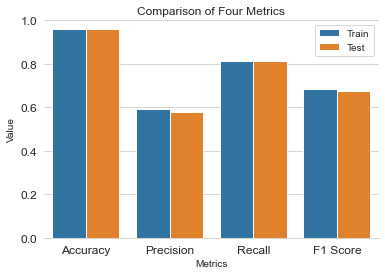

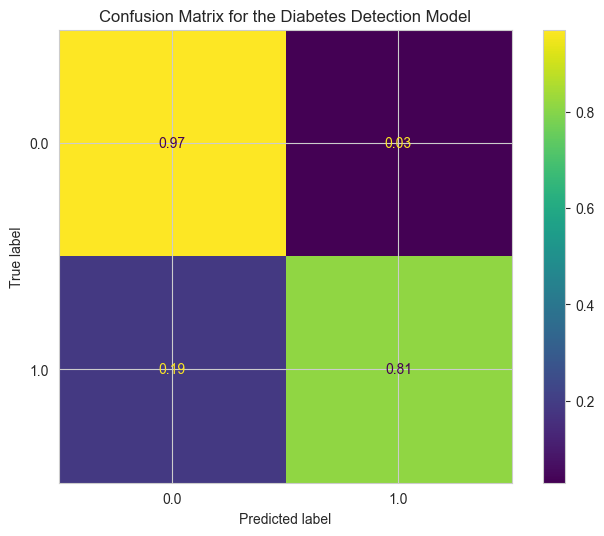

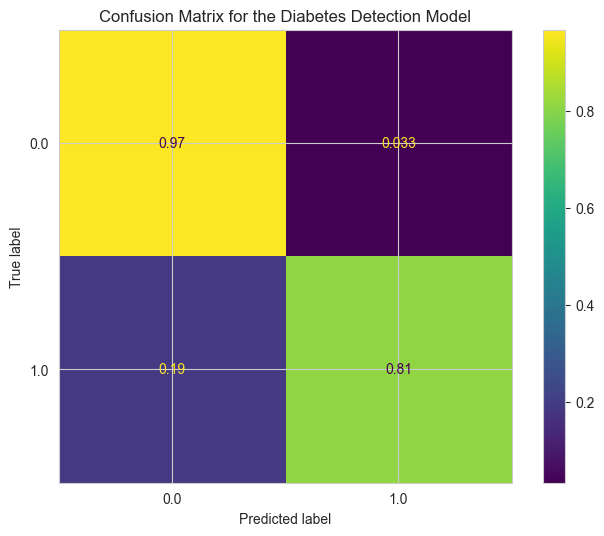


Women
	Train f1: 0.6769880365939479, Test f1: 0.6657789613848203
Men
	Train f1: 0.6966731898238747, Test f1: 0.689922480620155

Adults (18<Age<55)
	Train f1: 0.6860927152317882, Test f1: 0.653061224489796
Elderly (55<Age)
	Train f1: 0.6848341232227488, Test f1: 0.6857142857142857

###################################################
Model name: rows_1_ADA.pkl

Train Set Metrics:
Accuracy: 0.96
Precision: 0.55
Recall: 0.83
F1 Score: 0.66

Test Set Metrics:
Accuracy: 0.96
Precision: 0.55
Recall: 0.82
F1 Score: 0.66



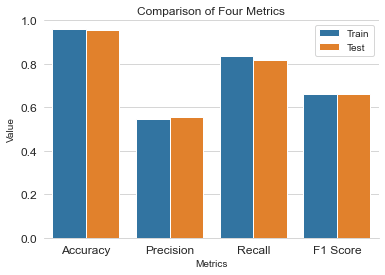

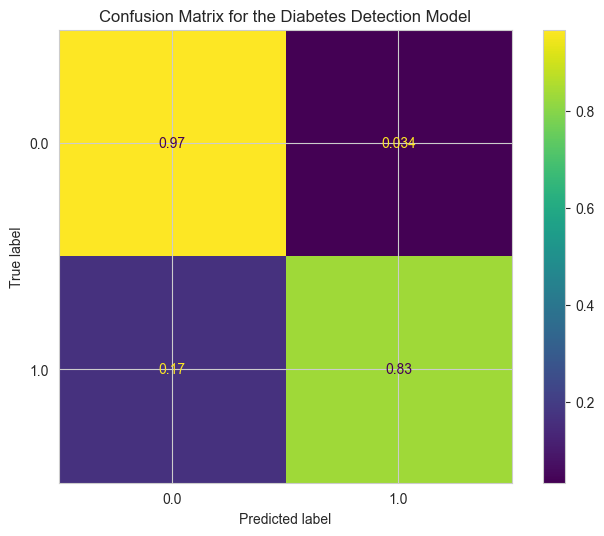

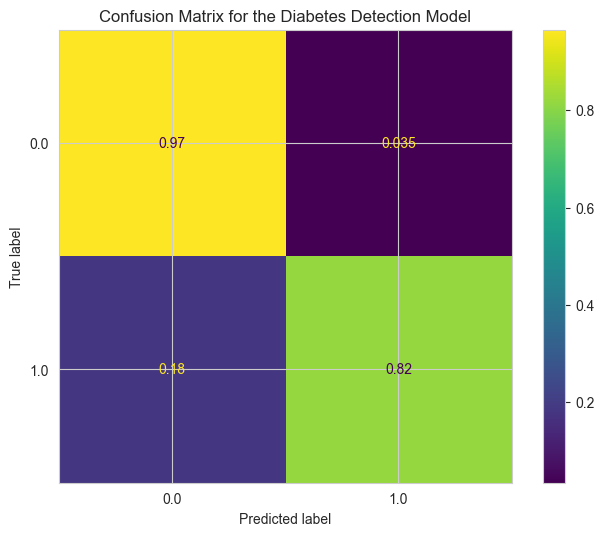


Women
	Train f1: 0.6622418879056048, Test f1: 0.6666666666666666
Men
	Train f1: 0.6578680203045685, Test f1: 0.652

Adults (18<Age<55)
	Train f1: 0.6693989071038251, Test f1: 0.6406249999999999
Elderly (55<Age)
	Train f1: 0.6563082660037289, Test f1: 0.6697674418604651

###################################################
Model name: rows_5_ADA.pkl

Train Set Metrics:
Accuracy: 0.96
Precision: 0.60
Recall: 0.82
F1 Score: 0.69

Test Set Metrics:
Accuracy: 0.96
Precision: 0.59
Recall: 0.79
F1 Score: 0.67



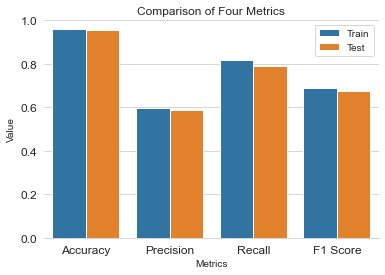

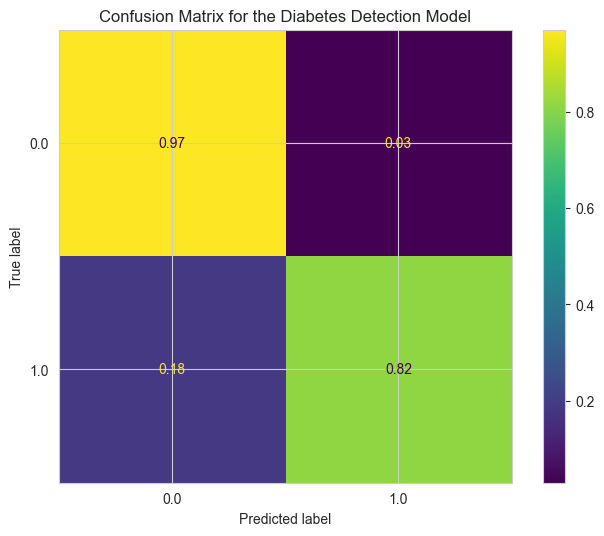

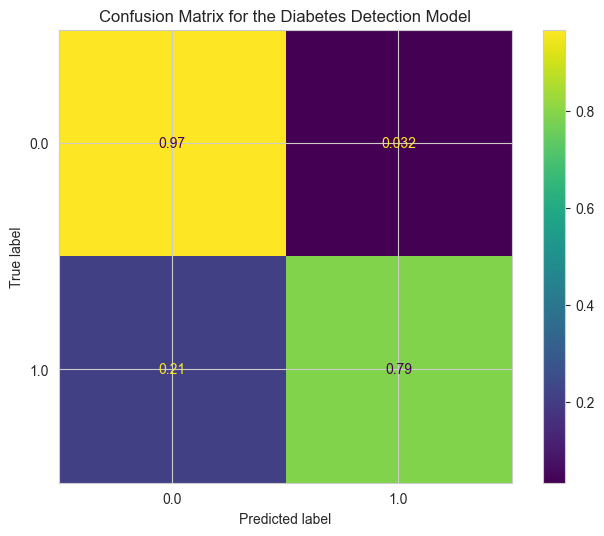


Women
	Train f1: 0.6881118881118882, Test f1: 0.6821106821106822
Men
	Train f1: 0.6914789422135161, Test f1: 0.6601562499999999

Adults (18<Age<55)
	Train f1: 0.6903820816864294, Test f1: 0.6666666666666666
Elderly (55<Age)
	Train f1: 0.6891252955082743, Test f1: 0.6764374295377676

###################################################


In [56]:
for model_name in adaboost:
    rows = int(model_name.split("_")[1])
    train_no_null, test_no_null = impute_null_values(prepare_df(train, rows_to_include=rows), prepare_df(test, rows_to_include=rows), 'mean', k=1)
    model = open_model(model_name)
    print(f"Model name: {model_name}")
    print()
    trainVtest(model, train_no_null, test_no_null)
    print()
    menVwomen(model, train_no_null, test_no_null)
    print()
    adultsVelderly(model, train_no_null, test_no_null)
    print()
    print("###################################################")

In [14]:
train_prof, test_prof = impute_null_values(prepare_df(train, rows_to_include=5), prepare_df(test, rows_to_include=5), None, k=1)
train_prof['sepsis'] = train_prof['label']
prof = ProfileReport(train_prof) 
prof.to_file(output_file='train.html')

# prof = ProfileReport(test_prof) 
# prof.to_file(output_file='test.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

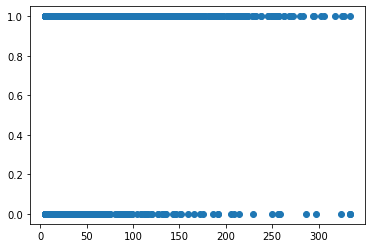

In [15]:
plt.scatter(x=train_prof.ICULOS, y=train_prof.label)

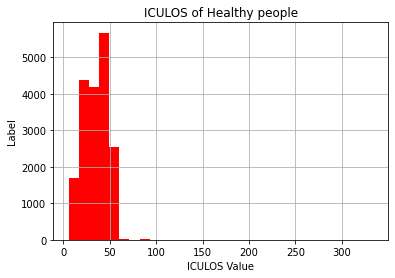

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


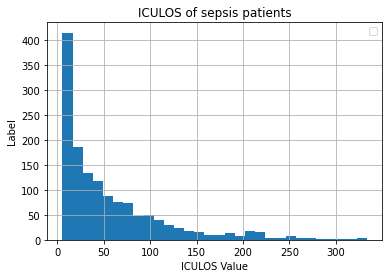

In [24]:
df = train_prof
df['ICULOS'][df['label'] == 0].hist(bins=30, color='red')
plt.xlabel('ICULOS Value')
plt.ylabel('Label')
plt.title('ICULOS of Healthy people')
plt.show()
df['ICULOS'][df['label'] == 1].hist(bins=30)

plt.xlabel('ICULOS Value')
plt.ylabel('Label')
plt.title('ICULOS of sepsis patients')

# show the legend
plt.legend()

# show the plot
plt.show()

